# ch 11. deep neural network 

이전 챕터에서 multilayer perceptron과 이를 학습시킬 수 있는 Back Propagation 알고리즘에 대해서 배웠습니다. 이번 챕터에서는 직접 여러 층으로 구성된 신경망 모델을 만들고, 학습시켜 보겠습니다.

## 데이터 셋 준비

이번 챕터부터는 딥러닝을 처음 시작할 때 많이 사용하는 대표적인 데이터 셋인 MNIST 데이터 셋을 사용해보도록 하겠습니다. 이는 0부터 9까지의 숫자의 손글씨 데이터 셋입니다. 이미지를 보고, 어느 숫자인지 분류하는 딥러닝 모델을 구축해보도록 하겠습니다.

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [3]:
train_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

val_dataset = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [4]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

## Single Layer Perceptron Classifier

층이 하나로 구성된 분류 모델을 만들어보겠습니다. 이전 시간에 배웠던 multiclass classifier와 동일한 모델입니다. 이미지를 일렬로 쫙 펼치기 때문에 첫번째 fully connected layer의 차원은 (28 * 28, hidden_dim)이 됩니다.

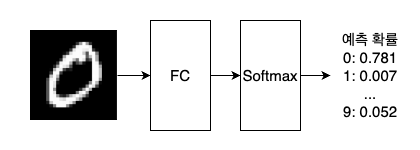

### 모델 작성

In [5]:
import torch

class SingleLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = torch.nn.Linear(input_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # flatten image
        x = x.view(x.size(0), -1) 
        x = self.softmax(self.fc(x))
        return x

In [3]:
model = SingleLayerPerceptron(input_dim=28*28, output_dim=10)

NameError: name 'SingleLayerPerceptron' is not defined

In [9]:
from torchsummary import summary

summary(model, input_size=(28, 28, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
           Softmax-2                   [-1, 10]               0
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### 하이퍼 파라미터 셋팅

In [10]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss() 
epochs = 10

### 학습

In [11]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [12]:
from sklearn.metrics import accuracy_score
from collections import defaultdict 
import numpy as np
from tqdm import tqdm

def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = torch.argmax(outputs, dim=1)
        acc = accuracy_score(y_train, pred)
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [13]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())
            
            pred = torch.argmax(outputs, dim=1)
            acc = accuracy_score(y_val, pred)
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [1]:
from collections import defaultdict

def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [2]:
logs = train_validate_model(model)

NameError: name 'model' is not defined

### 결과 시각화

In [13]:
from matplotlib import pyplot as plt

def plot_loss_acc(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

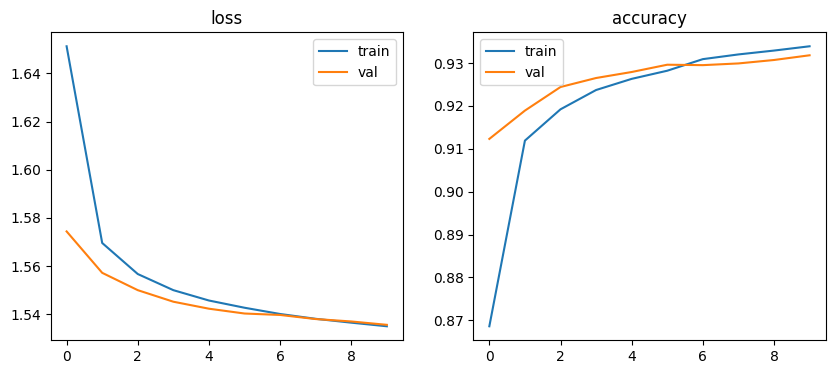

In [14]:
plot_loss_acc(logs)

## Multilayer Perceptron Classifier
입력으로 들어오는 이미지를 일렬로 쭉 펼친 다음, 신경망을 2번 통과시키는 모델을 작성합니다. 활성화 함수로는 sigmoid를 사용합니다. 구조를 시각화 해보면 아래와 같습니다.

이미지를 일렬로 쫙 펼치기 때문에 첫번째 fully connected layer의 차원은 (28 * 28, hidden_dim)이 됩니다.

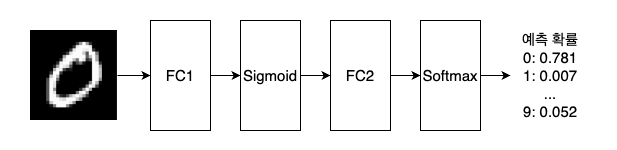


### 모델 작성

In [18]:
import torch

class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MultiLayerPerceptron, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)
        self.activation = torch.nn.Sigmoid()

    def forward(self, x):
        # flatten image
        x = x.view(x.size(0), -1) 
        x = self.activation(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [19]:
model = MultiLayerPerceptron(input_dim=28*28, hidden_dim=50, output_dim=10)

In [20]:
summary(model, input_size=(28, 28, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]          39,250
           Sigmoid-2                   [-1, 50]               0
            Linear-3                   [-1, 10]             510
           Softmax-4                   [-1, 10]               0
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


### 하이퍼 파라미터 셋팅

In [21]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss() 
epochs = 10

### 학습

In [17]:
logs = train_validate_model(model)

100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 815.70it/s]


epoch 1 train - loss: 1.7115 acc: 0.808 val - loss: 1.5685 acc: 0.9178


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 816.91it/s]


epoch 2 train - loss: 1.5528 acc: 0.9272 val - loss: 1.5404 acc: 0.9336


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 810.14it/s]


epoch 3 train - loss: 1.5335 acc: 0.9407 val - loss: 1.5277 acc: 0.9427


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 815.73it/s]


epoch 4 train - loss: 1.5226 acc: 0.9488 val - loss: 1.5207 acc: 0.9487


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 810.96it/s]


epoch 5 train - loss: 1.5153 acc: 0.9547 val - loss: 1.5162 acc: 0.9528


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 800.72it/s]


epoch 6 train - loss: 1.5095 acc: 0.9599 val - loss: 1.5126 acc: 0.9555


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 809.33it/s]


epoch 7 train - loss: 1.5053 acc: 0.9637 val - loss: 1.5098 acc: 0.9576


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 825.02it/s]


epoch 8 train - loss: 1.5016 acc: 0.9665 val - loss: 1.5085 acc: 0.9594


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 822.46it/s]


epoch 9 train - loss: 1.4986 acc: 0.9694 val - loss: 1.5062 acc: 0.9602


100%|████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 810.72it/s]

epoch 10 train - loss: 1.496 acc: 0.9713 val - loss: 1.5048 acc: 0.9607


### 결과 시각화

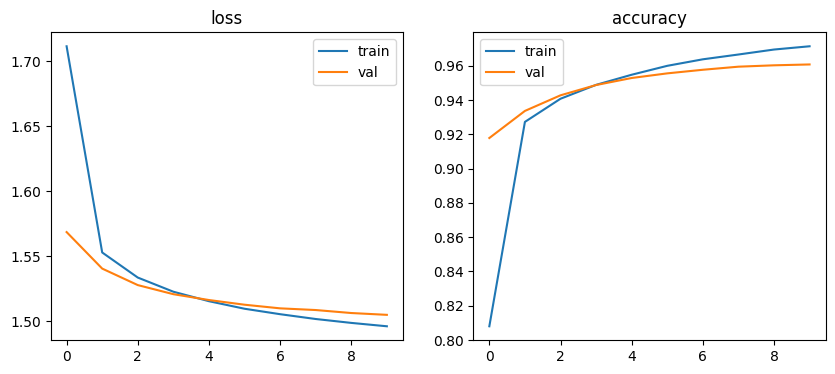

In [18]:
plot_loss_acc(logs)

층을 하나 더 쌓았을 뿐인데 모델의 정확도가 96.8%까지 개선되는 것을 확인할 수 있습니다.

## 정리

이번 챕터에서는 여러개의 층으로 구성된 신경망 모델을 만들고, MNIST 데이터 셋에 대해서 학습을 시켜보았습니다. 그 결과 96%라는 준수한 성능을 보여주었습니다. 실습 과정에서 사용한 코드 구성은 모델이 더 복잡해지더라도 대부분 적용할 수 있는 코드들이므로 사용법을 잘 숙지하시기 바랍니다.